In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import itertools
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing
from CustomFunctions import PCvisualization, DetailedBalance


def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [2]:
#get directories and open separated datasets

treatments = ['DMSO','Para-Nitro-Blebbistatin']
time_interval = 10 #sec/frame
whichpcs = ['PC1','PC7']

#get directories and open separated datasets
basedir = 'E:/Aaron/Combined_37C_Confocal_PCA_smooth/'
datadir = basedir + 'Data_and_Figs/'
savedir = basedir + 'Para-Nitro-Blebbistatin/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)


nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)


#limit data to the Para-Nitro-Blebbistatin experiments
TotalFrame = FullFrame[FullFrame.Experiment == 'Drug']
dates = [20240624,20240626,20240701,20241125,20241126,20241127]
TotalFrame = TotalFrame[TotalFrame.Date.isin(dates)]
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=treatments, ordered=True)

In [3]:
######## open all of the data

########### get raw transitions and pairs ###########
rawtrans = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_transitions_separated.csv', index_col = 0)
rawpairs = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_transition_pairs_separated.csv', index_col = 0)

########### interpolate all transitions so that only individual transitions are made ###########
transdf_sep = pd.read_csv(savedir+f'interpolated_{whichpcs[0]}-{whichpcs[1]}_transitions_separated.csv', index_col=0)
transpairsdf_sep = pd.read_csv(savedir+f'interpolated_{whichpcs[0]}-{whichpcs[1]}_transition_pairs_separated.csv', index_col=0) 
#ensure that DMSO is the first in order
transdf_sep['Treatment'] = pd.Categorical(transdf_sep.Treatment, categories=treatments, ordered=True)
transdf_sep = transdf_sep.sort_values(by='Treatment')
transpairsdf_sep['Treatment'] = pd.Categorical(transpairsdf_sep.Treatment, categories=treatments, ordered=True)
transpairsdf_sep = transpairsdf_sep.sort_values(by='Treatment')

############## get the counts of cells leaving 
trans_rate_df_sep = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_binned_transition_rates_separated.csv', index_col=0)
#ensure that DMSO is the first in order
trans_rate_df_sep['Treatment'] = pd.Categorical(trans_rate_df_sep.Treatment, categories=treatments, ordered=True)
trans_rate_df_sep = trans_rate_df_sep.sort_values(by='Treatment')

############## BOOTSTRAP MANY TRAJECTORIES ##########
#open bootstrapped transitions
bstrans = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transitions.csv', index_col=0)
bstrans['Treatment'] = pd.Categorical(bstrans.Treatment, categories=treatments, ordered=True)
bstrans = bstrans.sort_values(by='Treatment')
#open bootstrapped CGPS rates
bsframe_sep_full = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transition_rates.csv', index_col=0)
#ensure that DMSO is the first in order
bsframe_sep_full['Treatment'] = pd.Categorical(bsframe_sep_full.Treatment, categories=treatments, ordered=True)
bsframe_sep_full = bsframe_sep_full.sort_values(by='Treatment')

############# open average bootstrapped currents ###################
bsfield_sep = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_bootstrapped_transitions_average_currents.csv', index_col=0)
#ensure that DMSO is the first in order
bsfield_sep['Treatment'] = pd.Categorical(bsfield_sep.Treatment, categories=treatments, ordered=True)
bsfield_sep = bsfield_sep.sort_values(by='Treatment')

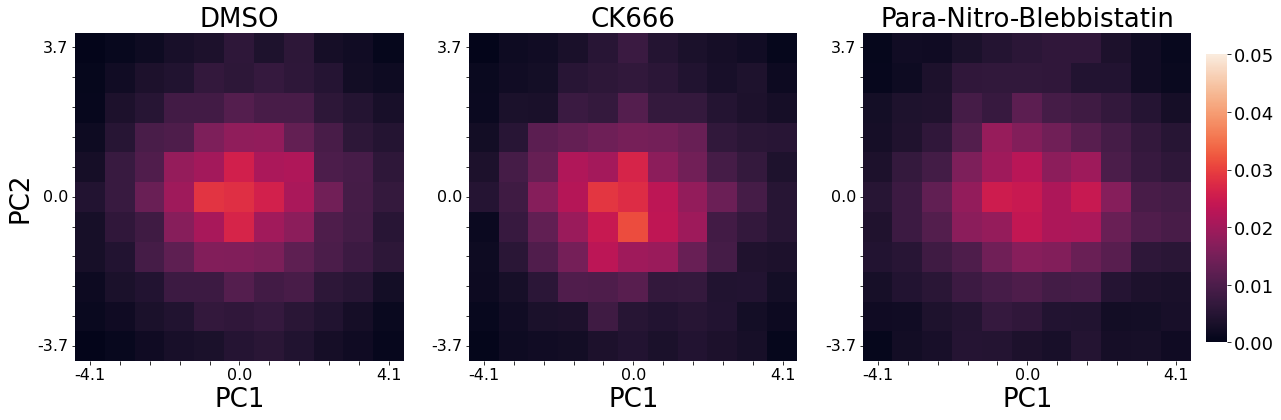

In [4]:
########### PLOT THE % TOTAL TIME SPENT IN CGPS OF THE SEPARATED MIGRATION MODES #############

fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique()),figsize=(20,10))
#single colorbar axis
cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = transdf_sep.Treatment.unique()[i]
    mdf = transdf_sep[transdf_sep.Treatment==mm]
    ttot = mdf.time_elapsed.sum()
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.sum()/ttot

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=0, vmax=0.035, #center=0,
        cmap='rocket',#sns.diverging_palette(220, 20, n=200),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round(x,1) for x in centers.PC1.to_list()],
        fontsize = 16
    )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC7.to_list()],
        rotation=0,
        fontsize = 16
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 26)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC7', fontsize = 26)
    
plt.savefig(savedir + 'PC1_PC7 TIME probability density heatmap separated.png', bbox_inches='tight')

In [15]:
t

'DMSO'

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


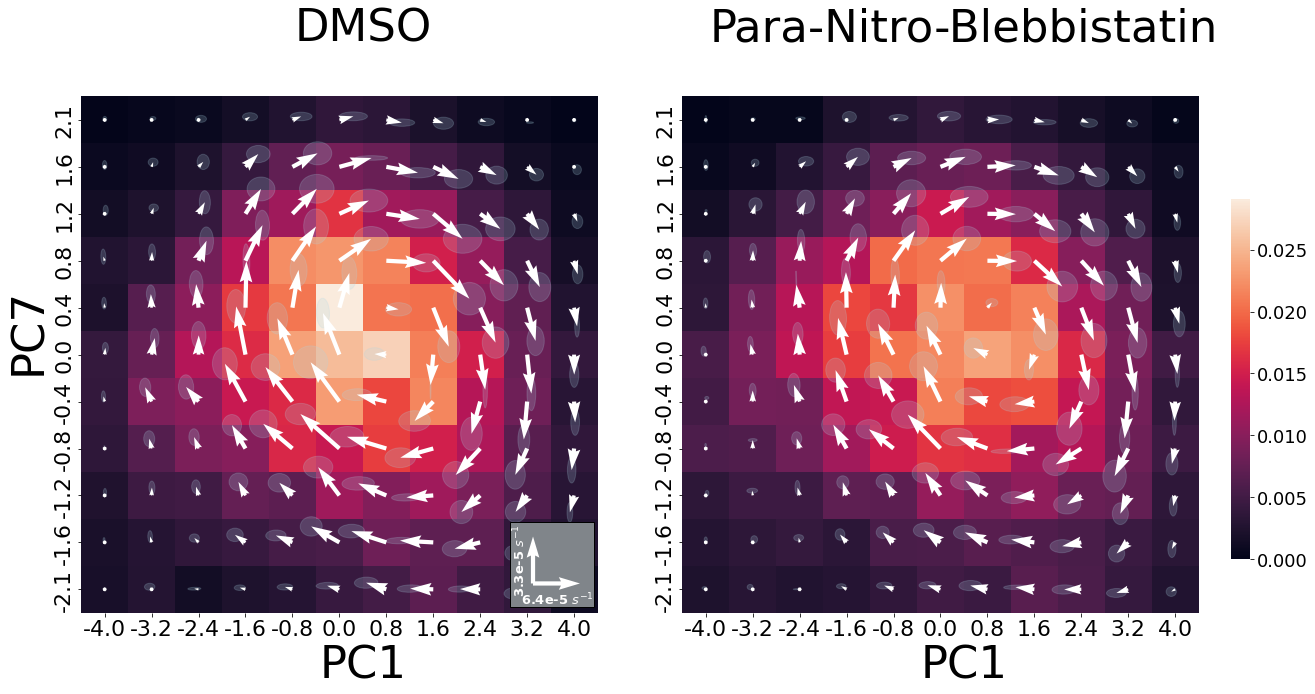

In [4]:
########### PDFs AND PROBABILITY FLUX OF THE SEPARATED Treatments #############
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords
# inverse scale for arrows
scale = 0.0008


# combine error data with real transition data
elldf = bsfield_sep.merge(trans_rate_df_sep,left_on = ['x','y','Treatment'], right_on = ['x','y','Treatment'])
# elldf = trans_rate_df_sep.copy()

fig, graphaxes = plt.subplots(1,len(elldf.Treatment.unique()),figsize=(7.5+(10*(len(elldf.Treatment.unique())-1)),10))
#single colorbar axis
cbar_ax = fig.add_axes([.98, .2, .015, .5])
################ heatmap of probability density #############
bighm = np.zeros((len(transdf_sep.Treatment.unique()),nbins,nbins))
for i,(t, mdf) in enumerate(transdf_sep.groupby('Treatment')):
    #get total time observed in the system
    ttot = mdf.time_elapsed.sum()
    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[i,y,x] = 0
            else:
                bighm[i,y,x] = current.time_elapsed.sum()/ttot
for i, ax in enumerate(graphaxes):
    #plot heatmap with seaborn
    sns.heatmap(
        bighm[i],
        vmin=0, vmax=bighm.max(), #center=0,
        cmap='rocket',
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
  
    ######################### vector map of probability flux ################
    mm = elldf.Treatment.unique()[i]
    mdf = elldf[elldf.Treatment==mm]
    
    
    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2

            ell = Ellipse(xy=(x-0.5+(xcurrent.values*(1/scale)),y-0.5+(ycurrent.values*(1/scale))),
                    width=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1x.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                      height=np.sqrt(abs(current.eval1)*(1/scale)) if current.evec1y.values[0] == 1 else np.sqrt(abs(current.eval2)*(1/scale)),
                    angle=np.arctan2(current.evec1y,current.evec1x),
                     color = 'lightblue')
            ax.add_artist(ell)
            ell.set_alpha(0.2)
    
    
    for x in range(1,nbins+1):
        for y in range(1,nbins+1):
            current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
            xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
            ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
            ax.quiver(x-0.5,
                       y-0.5, 
                       xcurrent,
                       ycurrent,
                      angles = 'xy',
                      scale_units = 'xy',
                      scale = scale,
#                       width = 0.012,
#                       minlength = 0.8,
                      color = 'white')
            
            
                    


    # axis label stuff
    ax.set_xlabel('PC1', fontsize = 45)
    ax.set_xticks(np.arange(0.5,nbins+0.5))
    ax.set_xticklabels([round(x,1) for x in centers.PC1.to_list()], fontsize = 22)
    ax.set_yticks(np.arange(0.5,nbins+0.5))
    ax.set_yticklabels([round(x,1) for x in centers.PC7.to_list()], fontsize = 22)
    ax.set_xlim(0,nbins+1)
    ax.set_ylim(0,nbins+1)
    ax.set_title(mm, fontsize = 45, loc = 'center',pad = -100)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
graphaxes[0].set_ylabel('PC7', fontsize = 45)
    


########## add scale for the vectors ##########
#legend background
lxp = 9.125
lyp = 0.125
rect = Rectangle((lxp, lyp), 1.8, 1.8, linewidth=1, edgecolor='black', facecolor='#80858a')
graphaxes[0].add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(centers.PC1).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
graphaxes[0].text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(centers.PC7).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
graphaxes[0].text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
    


plt.tight_layout()
plt.savefig(savedir + 'PC1_PC7 probability flux and pdf separated.png', bbox_inches='tight')


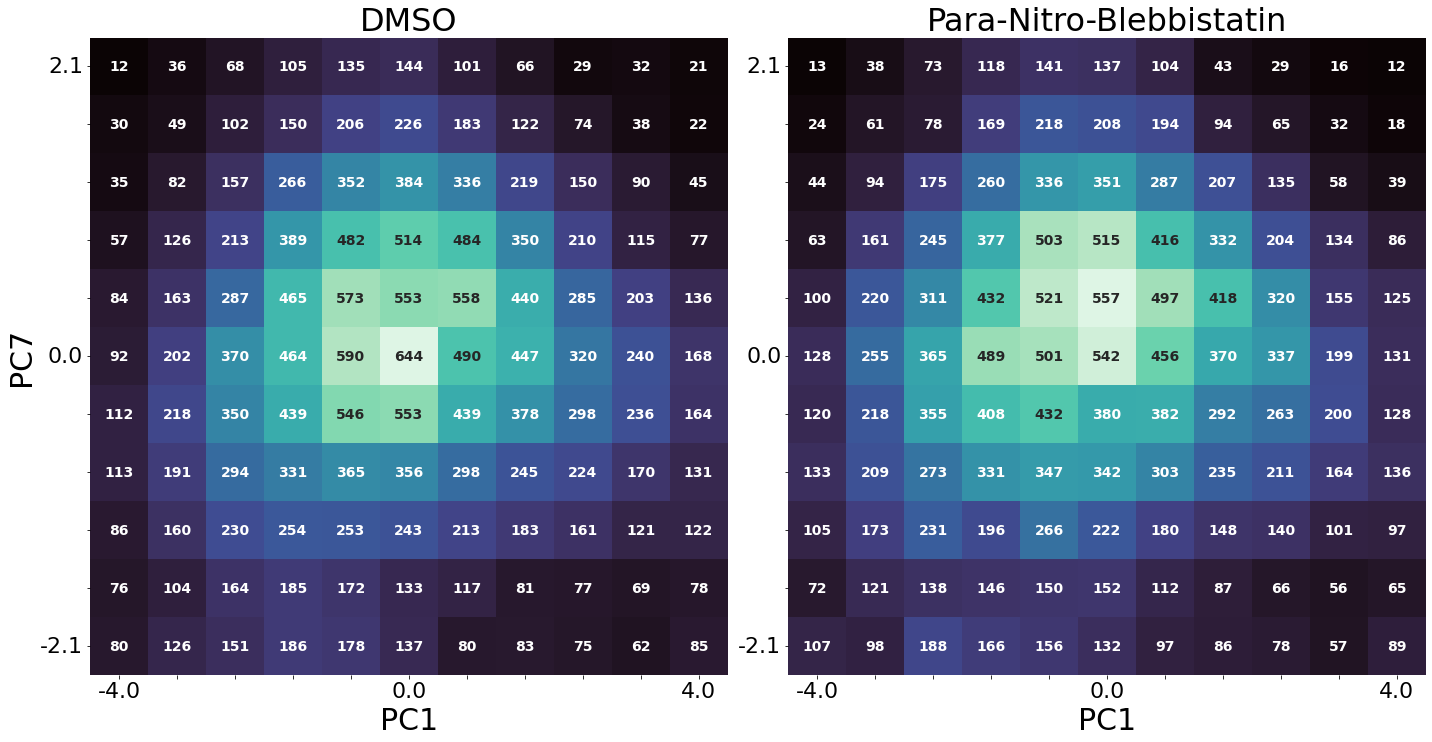

In [5]:
########### PLOT THE CELL COUNTS OF THE BINS OF THE SEPARATED MIGRATION MODES #############

fig, axes = plt.subplots(1,len(TotalFrame.Treatment.unique()),figsize=(20,10))
#single colorbar axis
# cbar_ax = fig.add_axes([.91, .3, .015, .4])

for i, ax in enumerate(axes):
    mm = TotalFrame.Treatment.unique()[i]
    mdf = TotalFrame[TotalFrame.Treatment==mm]
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC7bins'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = len(current)

        
    #plot heatmap with seaborn
    sns.heatmap(
        bighm,
        vmin=np.min(bighm[np.nonzero(bighm)]),
        vmax=bighm.max(), #center=0,
        cmap='mako',#sns.light_palette('#004a27', as_cmap=True),
        square=True,
        xticklabels = True,
        yticklabels = True,
        annot = True,
        annot_kws={"size":14,
                  'fontweight':'bold'},
        fmt = '.0f',
        ax = ax,
        cbar=False,
#         cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round(x,1) for x in centers.PC1.to_list()],
        fontsize = 22
    )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC7.to_list()],
        rotation=0,
        fontsize = 22
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 30)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes[0].set_ylabel('PC7', fontsize = 30)
plt.tight_layout()
plt.savefig(savedir + 'PC1_PC7 cell counts heatmap separated.png', bbox_inches='tight', dpi = 500)

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator


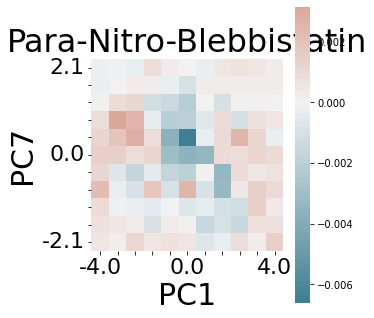

In [6]:
########### plot the PDF DIFFERENCE of the treatments in the CGPS #############

fig, ax = plt.subplots(1,1,figsize=(5,5))
#single colorbar axis
# cbar_ax = fig.add_axes([.999, .21, .015, .58])

#calculate control heatmap to subtract from the treatments
mm = transdf_sep.Treatment.unique()[0]
mdf = transdf_sep[transdf_sep.Treatment=='DMSO']
ttot = mdf.time_elapsed.sum()
################ heatmap of probability density #############
#make numpy array with heatmap data
ctrlhm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
        if current.empty:
            ctrlhm[y,x] = 0
        else:
            ctrlhm[y,x] = current.time_elapsed.sum()/ttot



mm = transdf_sep.Treatment.unique()[1]
mdf = transdf_sep[transdf_sep.Treatment==mm]
ttot = mdf.time_elapsed.sum()
################ heatmap of probability density #############
#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot


difference = bighm-ctrlhm

#plot heatmap with seaborn
sns.heatmap(
    difference,
#         vmin=2.5, vmax=9, 
    center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    ax = ax,
#     cbar=i==0,
    cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 22
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC7.to_list()],
    rotation=0,
    fontsize = 22
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)

#correct axis orientations
ax.invert_yaxis()
#set title
ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=24)
#set axis title
ax.set_ylabel('PC7', fontsize = 30)
plt.tight_layout()
# plt.savefig(savedir + 'PC1_PC7 probability density DIFFERENCE heatmap separated.png', bbox_inches='tight', dpi = 500)

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


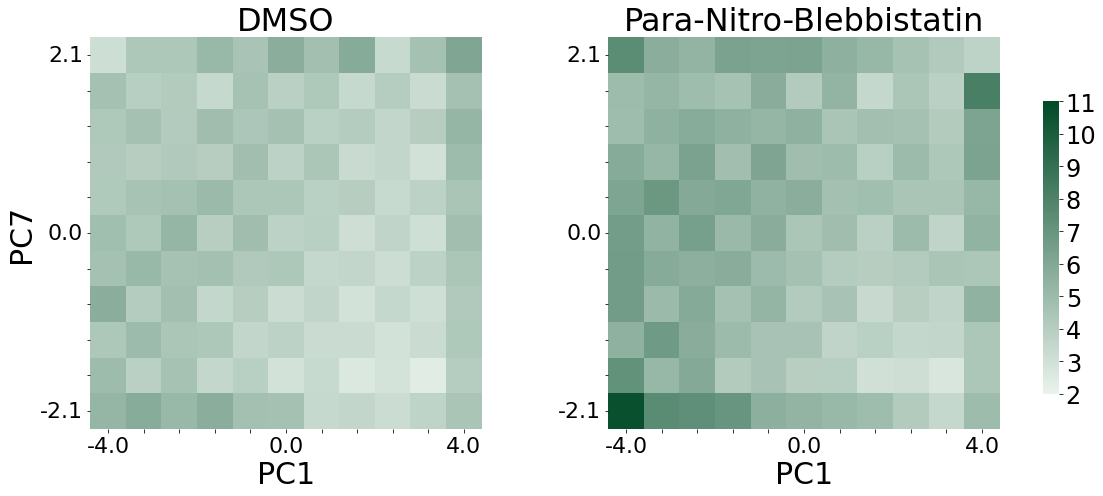

In [6]:
########### PLOT THE DWELL TIME OF THE MIGRATION MODES IN THE CGPS #############

fig, axes = plt.subplots(1,len(transdf_sep.Treatment.unique()),figsize=(15,7))
#single colorbar axis
cbar_ax = fig.add_axes([.999, .21, .015, .58])

allmax = 0
for i, ax in enumerate(axes):
    mm = transdf_sep.Treatment.unique()[i]
    mdf = transdf_sep[transdf_sep.Treatment==mm]
    ################ heatmap of probability density #############
    #make numpy array with heatmap data
    bighm = np.zeros((nbins,nbins))
    #get total time observed in the system

    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[y,x] = 0
            else:
                bighm[y,x] = current.time_elapsed.mean()

        
    #plot heatmap with seaborn
    allmax = bighm.max() if bighm.max()>allmax else allmax.copy()
    
    sns.heatmap(
        bighm,
        vmin=2, vmax=11, #center=0,
        cmap=sns.light_palette('#004a27', as_cmap=True),
        square=True,
        xticklabels = True,
        yticklabels = True,
        ax = ax,
        cbar=i==0,
        cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
    )
    ax.set_xticklabels(
        [round(x,1) for x in centers.PC1.to_list()],
        fontsize = 22
    )
    ax.set_yticklabels(
        [round(x,1) for x in centers.PC7.to_list()],
        rotation=0,
        fontsize = 22
    )
    #take out all axis labels except the desired ones
    for i, l in enumerate(ax.xaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    for i, l in enumerate(ax.yaxis.get_ticklabels()):
        if i%5 != 0:
            l.set_visible(False)
    #set axis titles
    ax.set_xlabel('PC1', fontsize = 30)

    #correct axis orientations
    ax.invert_yaxis()
    #set title
    ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=24)
#set axis title
axes[0].set_ylabel('PC7', fontsize = 30)
plt.tight_layout()
plt.savefig(savedir + 'PC1_PC7 probability dwell time heatmap separated.png', bbox_inches='tight', dpi = 500)

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator


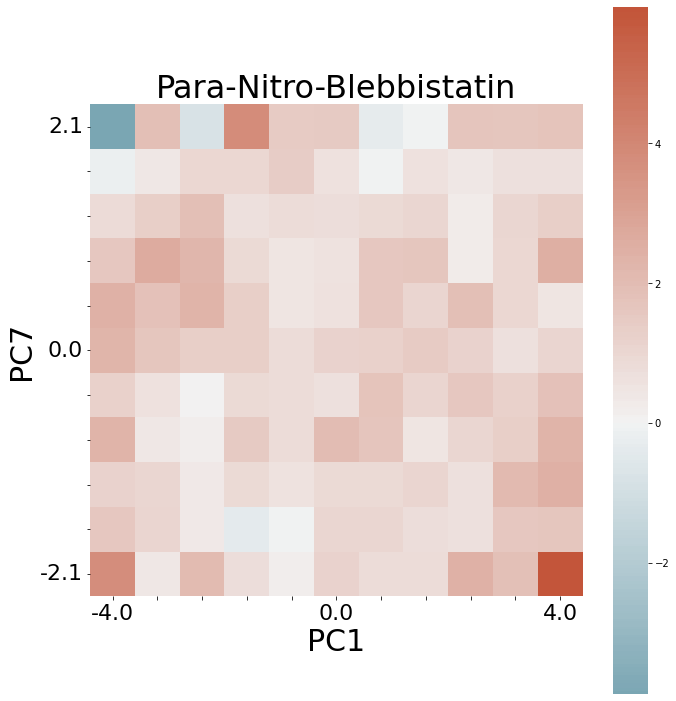

In [44]:
########### plot the DWELL TIME DIFFERENCE of the treatments in the CGPS #############

fig, ax = plt.subplots(1,1,figsize=(10,10))
#single colorbar axis
# cbar_ax = fig.add_axes([.999, .15, .015, .85])

#calculate control heatmap to subtract from the treatments
mm = transdf_sep.Treatment.unique()[0]
mdf = transdf_sep[transdf_sep.Treatment==treatments[0]]
ttot = mdf.time_elapsed.sum()
################ heatmap of probability density #############
#make numpy array with heatmap data
ctrlhm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
        if current.empty:
            ctrlhm[y,x] = 0
        else:
            ctrlhm[y,x] = current.time_elapsed.mean()



mm = transdf_sep.Treatment.unique()[1]
mdf = transdf_sep[transdf_sep.Treatment==mm]
ttot = mdf.time_elapsed.sum()
################ heatmap of probability density #############
#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.mean()


difference = bighm-ctrlhm

#plot heatmap with seaborn
sns.heatmap(
    difference,
#         vmin=2.5, vmax=9, 
    center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    ax = ax,
#     cbar=i==0,
    cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 22
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC7.to_list()],
    rotation=0,
    fontsize = 22
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)

#correct axis orientations
ax.invert_yaxis()
#set title
ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=24)
#set axis title
ax.set_ylabel('PC7', fontsize = 30)
plt.tight_layout()
plt.savefig(savedir + f'{whichpcs[0]}_{whichpcs[1]} dwell time DIFFERENCE heatmap.png', bbox_inches='tight', dpi = 500)

In [40]:
bighm[1]-bighm[0]

array([[-5.47160267, -3.34077435,  0.68917486, -0.14761284, -0.65422379,
        -0.07723192, -0.030191  , -0.51115408,  0.08701134, -0.06403264,
        -0.46652702],
       [-1.6122449 , -2.55447988, -0.86676213, -0.86181623, -0.21874596,
        -0.11672189,  0.57266562, -0.69035763, -0.73322327, -1.79070685,
        -0.26106934],
       [-3.12199936,  0.92782678, -1.82048841, -0.75527456, -0.24623752,
        -0.33472894, -0.17036138,  0.57441947, -0.98696606, -0.75781287,
        -0.88305937],
       [-0.72283784, -0.56552051,  0.53047863, -0.53299196, -0.7959663 ,
        -1.08016472, -1.13370304, -0.28410677, -0.36277252, -1.21640792,
        -0.19204946],
       [-3.54955249,  0.42948155, -1.19058788, -0.80452187, -0.07518243,
         0.14559499, -0.77871934, -0.57070656, -1.07996557, -2.00478029,
        -1.21900816],
       [-1.02448008, -1.40979266, -2.19618026, -0.871655  , -0.63070625,
        -0.35087063, -0.74080113, -1.47974826, -1.43959251, -1.28534343,
         0.107

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Degrees of freedom <= 0 for slice
  from ipykernel import kernelapp as app
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator


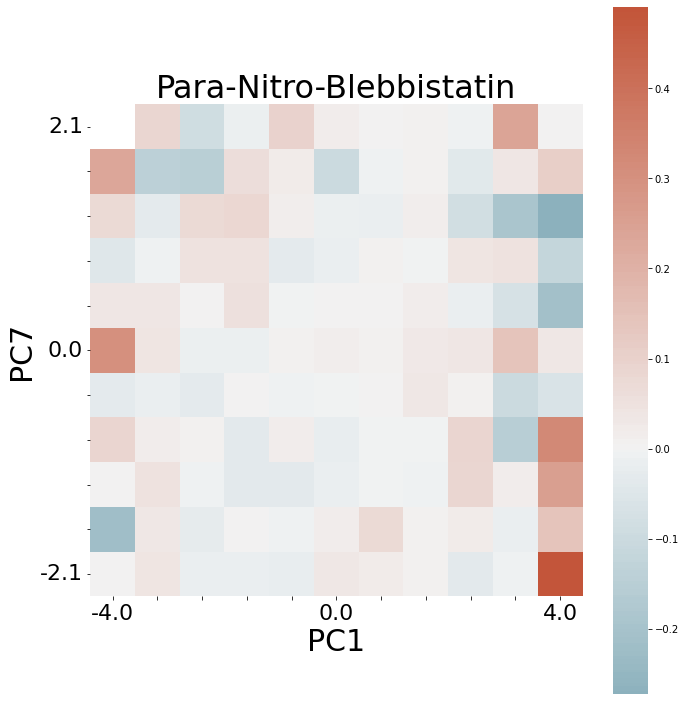

In [68]:
########## DIFFERENCES IN VARIANCE AT EACH POSTITION IN CGPS ###########

################ heatmap of variances #############
#make numpy array with heatmap data
bighm = np.zeros((len(treatments),nbins,nbins))
for i, (mm, mdf) in enumerate(transdf_sep.groupby('Treatment')):
    for x in range(nbins):
        for y in range(nbins):
            current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
            if current.empty:
                bighm[i,y,x] = 0
            else:
                #variance of the two variables is basically the sum of the covariance matrix
                #aka the variance of each variable and their covariances
                bighm[i,y,x] = np.sum(np.cov(current[['to_x','to_y']].values.T))

                
                
difference = bighm[1]-bighm[0]


fig, ax = plt.subplots(1,1,figsize=(10,10))
#plot heatmap with seaborn
sns.heatmap(
    difference,
#         vmin=2.5, vmax=9, 
    center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    ax = ax,
#     cbar=i==0,
    cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 22
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC7.to_list()],
    rotation=0,
    fontsize = 22
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel(whichpcs[0], fontsize = 30)

#correct axis orientations
ax.invert_yaxis()
#set title
ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=24)
#set axis title
ax.set_ylabel(whichpcs[1], fontsize = 30)
plt.tight_layout()
plt.savefig(savedir + f'{whichpcs[0]}_{whichpcs[1]} variance DIFFERENCE heatmap.png', bbox_inches='tight', dpi = 500)

In [93]:
bighm.shape

(2, 11, 11, 3000)

In [88]:
########## DIFFERENCES IN VARIANCE AT EACH POSTITION IN CGPS USING THE BOOTSTRAPPED DATA ###########

################ heatmap of variances #############
#make numpy array with heatmap data
bighm = np.zeros((len(treatments),nbins,nbins,bstrans['iter'].max()))
for i, (mm, mdf) in enumerate(bstrans.groupby('Treatment')):
    for x in range(nbins):
        for y in range(nbins):
            for j in range(bstrans['iter'].max()):
                current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1) & (mdf['iter']==j)]
                if current.empty:
                    bighm[i,y,x,j] = 0
                else:
                    #variance of the two variables is basically the sum of the covariance matrix
                    #aka the variance of each variable and their covariances
                    bighm[i,y,x,j] = np.sum(np.cov(current[['to_x','to_y']].values.T))
##### do the t tests between the treatments
thm = np.zeros((nbins,nbins))
for x in range(nbins):
    for y in range(nbins):
        t, p = scipy.stats.ttest_ind(bighm[0,y,x,:],bighm[1,y,x,:])
        thm[y,x] = p
                
np.where(thm<0.05)

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Degrees of freedom <= 0 for slice
  
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


(array([], dtype=int64), array([], dtype=int64))

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator


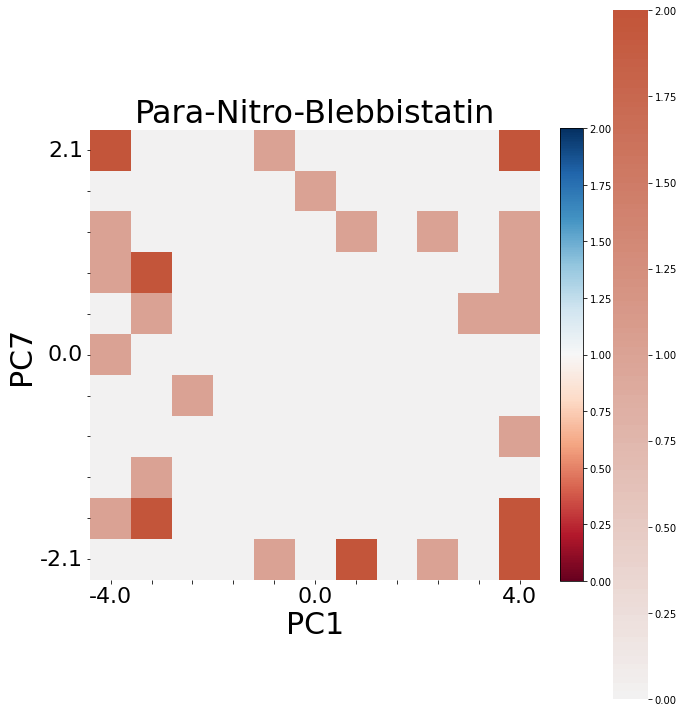

In [83]:
#### levene's tests for difference in variance using deviations from the mean
#### brown-forscythe test for difference in variance using deviations from the median


#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins, 2))
sighm = np.zeros((nbins,nbins))
for x in range(nbins):
    for y in range(nbins):
        current =  transdf_sep[(transdf_sep['from_x'] == x+1) & (transdf_sep['from_y'] == y+1)]
        if current.empty:
            bighm[y,x,:] = [0,0]
        else:
            for c in range(bighm.shape[-1]):
                #control
                ccc = current[current.Treatment == treatments[0]][['to_x','to_y']].values.T[c]
                #treatment
                cct = current[current.Treatment == treatments[1]][['to_x','to_y']].values.T[c]
                t, p = scipy.stats.levene(ccc,cct, center = 'mean')
                bighm[y,x,c] = p
                if p<0.05:
                    sighm[y,x] = sighm[y,x]+1
                    
##### graph a heatmap where 1 means 1 significantly different variance (x or y direction)
##### and 2 means 2 different


fig, ax = plt.subplots(1,1,figsize=(10,10))
#plot heatmap with seaborn
sns.heatmap(
    sighm,
#         vmin=2.5, vmax=9, 
    center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    ax = ax,
#     cbar=i==0,
    cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 22
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC7.to_list()],
    rotation=0,
    fontsize = 22
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel(whichpcs[0], fontsize = 30)

#correct axis orientations
ax.invert_yaxis()
#set title
ax.set_title(mm, fontsize = 32)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=24)
#set axis title
ax.set_ylabel(whichpcs[1], fontsize = 30)
# norm = matplotlib.colors.Normalize(vmin=sighm.min(), vmax=sighm.min())
plt.colorbar(ax.imshow(sighm, cmap='RdBu'),fraction=0.046, pad=0.04)
plt.tight_layout()
# plt.savefig(savedir + f'{whichpcs[0]}_{whichpcs[1]} variance DIFFERENCE heatmap.png', bbox_inches='tight', dpi = 500)


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator


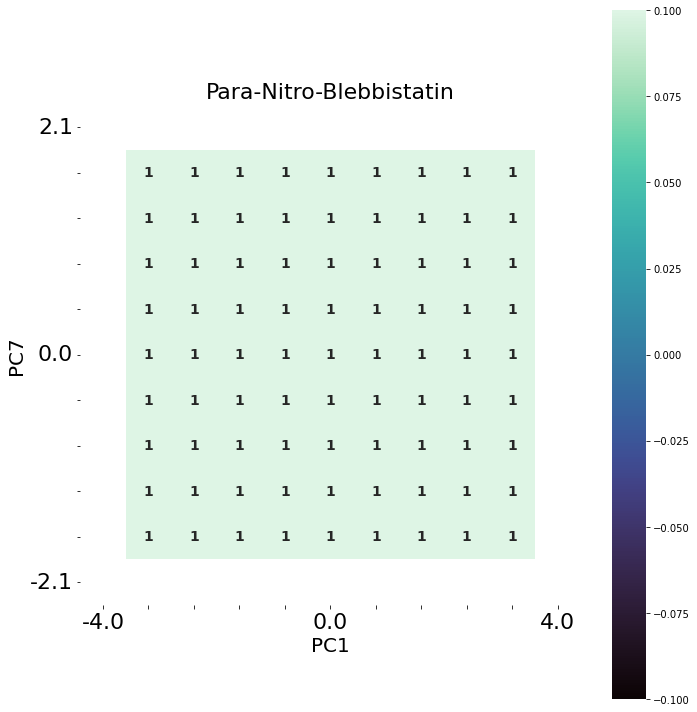

In [75]:
############## CHI SQUARE FOR FORWARD TRANSITIONS ###############

#### build heatmap
#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#loop through positions
for x in range(nbins):
    for y in range(nbins):
        current =  trans_rate_df_sep[(trans_rate_df_sep['x'] == x+1) & (trans_rate_df_sep['y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            counts = current[[x for x in current.columns.to_list() if 'count' in x and 'rev' not in x]+['Treatment']]
            #separate treatments
            ctrlcounts = counts[counts.Treatment == treatments[0]].drop(columns='Treatment').values[0]
            treatcounts = counts[counts.Treatment == treatments[1]].drop(columns='Treatment').values[0]
            #get frequencies
            ctrlcounts = ctrlcounts/ctrlcounts.sum()
            treatcounts = treatcounts/treatcounts.sum()
            #chi-square
            chi, pval = scipy.stats.chisquare(treatcounts,ctrlcounts)
            bighm[y,x] = pval

            
fig, ax = plt.subplots(1,1,figsize=(10,10))



#plot heatmap with seaborn
sns.heatmap(
    bighm,
    vmin=np.min(bighm[np.nonzero(bighm)]),
    vmax=bighm.max(), #center=0,
    cmap='mako',
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    annot_kws={"size":14,
              'fontweight':'bold'},
    fmt = '.0f',
    ax = ax,
#     cbar=i==0,
    cbar_ax = None if i else cbar_ax,
#         cbar_kws=cbar_kws
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 22
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC7.to_list()],
    rotation=0,
    fontsize = 22
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 20)

#correct axis orientations
ax.invert_yaxis()
#set title
ax.set_title(mm, fontsize = 22)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=16)
#set axis title
ax.set_ylabel('PC7', fontsize = 20)
plt.tight_layout()
# plt.savefig(savedir + 'PC1_PC7 probability density DIFFERENCE heatmap separated.png', bbox_inches='tight', dpi = 500)

In [7]:
############### calculate AER ###################
from CustomFunctions.DetailedBalance import get_area_enclosing_rate
aers = []
for m, mig in trans_rate_df_sep.groupby('Treatment'):
    a = get_area_enclosing_rate(mig, center = [5,6])
    aers.append(a.aer.sum())
    
aers

[0.09751651679802033, 0.10829711332886272, 0.06541362456813371]

In [11]:
############## bootstrapped AERs #################

xyscaling = [centers[whichpcs[0]].diff().mean(),centers[whichpcs[1]].diff().mean()]
center = [5,6]

if os.path.exists(savedir+f'{whichpcs[0]}-{whichpcs[1]}_Area_Enclosing_Rates.csv'):
    allaers = pd.read_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_Area_Enclosing_Rates.csv', index_col=0)
    allaers['Treatment'] = pd.Categorical(allaers.Treatment, categories=treatments, ordered=True)
    allaers = allaers.sort_values(by='Treatment')
    print('Opened AERs')
else:
    allaers = []
    for i, m in bstrans.groupby('Treatment'):
        start = 0
        stop = 200
        allresults = []

        while start<bstrans.iter.max():
            print(f'Finished {start}, starting {start}-{stop}')
            if __name__ ==  '__main__':
                pool = multiprocessing.Pool(processes=60)
                results = []
                for x in range(start,stop+1):
                    b = m[m.iter==x]
                    b = b.sort_values('cumulative_time').reset_index(drop = True)
                    pool.apply_async(DetailedBalance.get_area_enclosing_rate, args = (
                        b,
                        nbins,
                        xyscaling,
                        center,
                        ),
                        callback = collect_results)
                pool.close()
                pool.join()

                allresults.extend(results)

                start = stop + 1
                stop = stop + 200
                if stop>bstrans.iter.max():
                    stop = bstrans.iter.max()

        migboot = pd.concat(allresults)
        allaers.append(migboot)

    allaers = pd.concat(allaers).reset_index(drop=True)
    allaers.to_csv(savedir+f'{whichpcs[0]}-{whichpcs[1]}_Area_Enclosing_Rates.csv')

Finished 0, starting 0-200
Finished 201, starting 201-400
Finished 401, starting 401-600
Finished 601, starting 601-800
Finished 801, starting 801-1000
Finished 1001, starting 1001-1200
Finished 1201, starting 1201-1400
Finished 1401, starting 1401-1600
Finished 1601, starting 1601-1800
Finished 1801, starting 1801-2000
Finished 2001, starting 2001-2200
Finished 2201, starting 2201-2400
Finished 2401, starting 2401-2600
Finished 2601, starting 2601-2800
Finished 2801, starting 2801-3000
Finished 0, starting 0-200
Finished 201, starting 201-400
Finished 401, starting 401-600
Finished 601, starting 601-800
Finished 801, starting 801-1000
Finished 1001, starting 1001-1200
Finished 1201, starting 1201-1400
Finished 1401, starting 1401-1600
Finished 1601, starting 1601-1800
Finished 1801, starting 1801-2000
Finished 2001, starting 2001-2200
Finished 2201, starting 2201-2400
Finished 2401, starting 2401-2600
Finished 2601, starting 2601-2800
Finished 2801, starting 2801-3000


In [12]:
aerdata.groupby('Treatment').mean()

,frame,from_x,from_y,to_x,to_y,time_elapsed,cumulative_time,iter,aer
Treatment,,,,,,,,,
DMSO,15279.187937,1076.504165,1120.648117,1076.677774,1121.025325,1820.0,166530.0,273000.0,-6.277029
Para-Nitro-Blebbistatin,15716.442186,1049.399867,1125.620460,1049.388870,1125.869377,1820.0,166530.0,273000.0,-5.806986


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


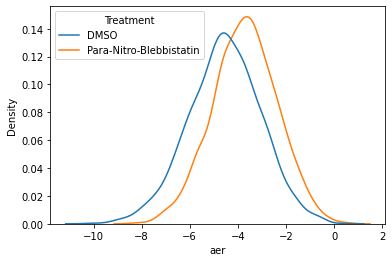

In [13]:
aerdata = allaers.groupby(['Treatment','iter']).apply(sum)
sns.kdeplot(data=aerdata,x='aer', hue='Treatment')
# plt.xlim(-0.3,0.3)
plt.savefig(savedir + 'Area Enclosing Rate Bootrap Distributions.png', bbox_inches='tight')

-11.482529609741702 1.6213906253768983e-30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


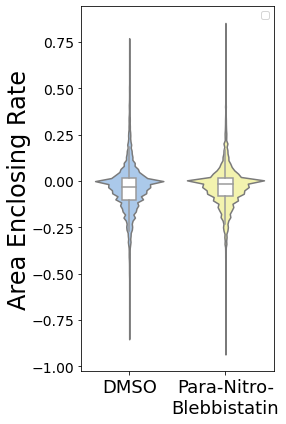

In [9]:
import scipy.stats as stats
t_statistic, p_value = stats.ttest_ind(allaers.loc[allaers.Treatment =='DMSO','aer'],
                                       allaers.loc[allaers.Treatment =='Para-Nitro-Blebbistatin','aer']) 
print(t_statistic , p_value)
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,8]]

fig, ax = plt.subplots(figsize=(4,6))#, sharex=True)
#plots
sns.violinplot(data=allaers.reset_index(), x = 'Treatment', y = 'aer',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=allaers.reset_index(),x = 'Treatment',y='aer', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('Area Enclosing Rate', fontsize=24, labelpad=0)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels(['DMSO','Para-Nitro-\nBlebbistatin'], fontsize = 18)
# ax.axhline(42,xmin=0.25, xmax = 0.75,color = 'black')
# ax.text(0.5,42,'***',fontdict= {'fontsize': 14,
#                                'horizontalalignment':'center'})


plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'area enclosing rate boostrap violins.png', bbox_inches='tight', dpi = 500)

In [22]:
######### do contour integrals for all migration modes ################
#upper left position of contour box
uple = [4,7]
#lower right position of contour box
lori = [9,2]


if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv'):
    omegaframesep = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv', index_col=0)
    individualoms = pd.read_csv(savedir+f'Individual_Contour_integrals_uple{uple}_lori{lori}_separated.csv', index_col=0)
    
    omegaframesep['Treatment'] = pd.Categorical(omegaframesep.Treatment, categories=treatments, ordered=True)
    omegaframesep = omegaframesep.sort_values(by='Treatment')
    individualoms['Treatment'] = pd.Categorical(individualoms.Treatment, categories=treatments, ordered=True)
    individualoms = individualoms.sort_values(by='Treatment')
else:
    omega_results = []
    dot_results = []
    for i, m in bsframe_sep_full.groupby('Treatment'):
        omegas = []
        dots = []
        for l, b in m.groupby('bs_iteration'):
            om, ol = contour_integral(b, uple, lori, False)
            omegas.append(om)
            dots.append(pd.DataFrame(ol))
        omega_results.append([i,omegas])
        tempdots = pd.concat(dots)
        tempdots['Treatment'] = pd.Categorical([i] * len(tempdots), categories=treatments, ordered=True)
        dot_results.append(tempdots)
    omegaframesep = pd.DataFrame([o[1] for o in omega_results], index = [o[0] for o in omega_results])
    dlist = []
    for m in omegaframesep.T.columns.to_list():
        dlist.append(pd.DataFrame(list(zip(omegaframesep.T[m].to_list(), [m]*len(omegaframesep.T))), columns=['bootstrap_omega','Treatment']))
    omegaframesep = pd.concat(dlist)
    omegaframesep.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_separated.csv')
    individualoms = pd.concat(dot_results)
    individualoms.columns = ['bs_iteration','x','y','dotprod','Treatment']
    individualoms.to_csv(savedir+f'Individual_Contour_integrals_uple{uple}_lori{lori}_separated.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


F value: 1898.7844512326274, p value: 0.0
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1          group2         meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
 CK666                    DMSO   -0.003  -0.0 -0.0032 -0.0028   True
 CK666 Para-Nitro-Blebbistatin  -0.0053  -0.0 -0.0056 -0.0051   True
  DMSO Para-Nitro-Blebbistatin  -0.0023  -0.0 -0.0025 -0.0021   True
--------------------------------------------------------------------


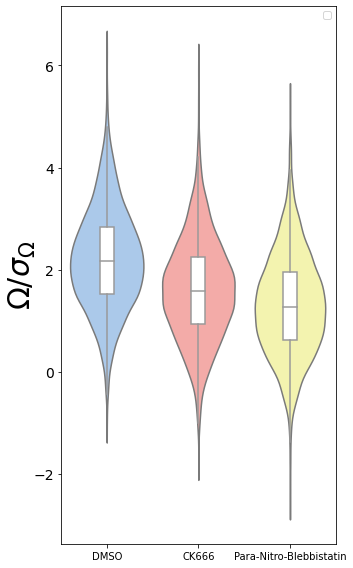

In [6]:
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

#calculate the normalized omegas
stds = []
for i,m in omegaframesep.groupby('Treatment'):
    stds.extend(m.bootstrap_omega/m.bootstrap_omega.std())
omegaframesep['Norm_Omegas'] = stds

fig, ax = plt.subplots(figsize=(5,8))#, sharex=True)
#plots
sns.violinplot(data=omegaframesep, x='Treatment', y='Norm_Omegas', 
               palette = colorlist, inner = None, ax=ax,) #order=['Random', 'Chem_Directed', 'Galv'])
sns.boxplot(data=omegaframesep, x='Treatment', y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax,) #order=['Random', 'Chem_Directed', 'Galv'])

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
# ax.set_xticklabels(['Random','Chemotaxis','Galvanotaxis'], fontsize = 14)



plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} separated.png', bbox_inches='tight')


import scipy.stats as ss


f_val, p_val = ss.f_oneway(*[m.bootstrap_omega.to_list() for i,m in omegaframesep.groupby('Treatment')])
print(f'F value: {f_val}, p value: {p_val}')
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(pairwise_tukeyhsd(omegaframesep.bootstrap_omega, omegaframesep.Treatment))



In [108]:
currenttreat[[x for x in currenttreat.columns.to_list() if 'count' in x and 'rev' not in x]].to_numpy()[0], currentcontrol[[x for x in currentcontrol.columns.to_list() if 'count' in x and 'rev' not in x]].to_numpy()

(array([ 2,  8,  4, 13], dtype=int64), array([[ 4, 11,  9, 26]], dtype=int64))

In [47]:
############### get shcoeffs for different positions around a particular 2d contour #############
from CustomFunctions.PCanimation import interpolate_contour_shapes
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()

pca = pk.load(open(savedir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10

fourcorners = np.array([[4,7],
[4,3],
[9,3],
[9,7]])

contour_positions, loopname = interpolate_contour_shapes(fourcorners,
                               avgpcs,
                               whichpcs,
                               pca,
                               PC1bins,
                               PC7bins,
                               savedir,
                               lmax)

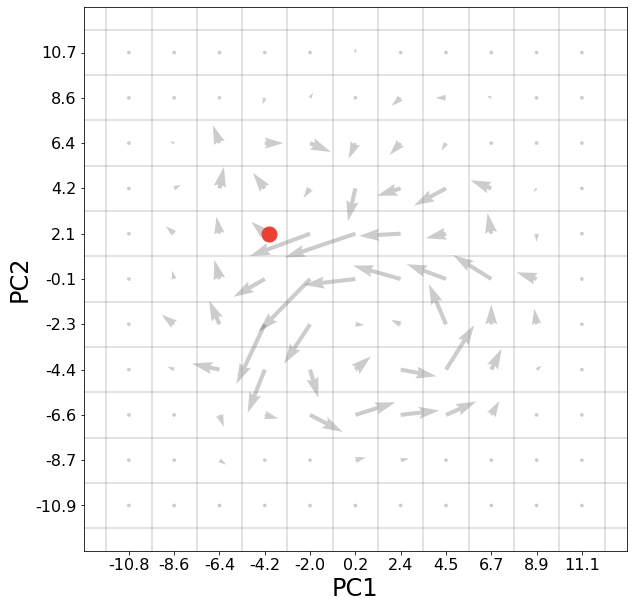

In [48]:
########## animate a contour loop graph
from matplotlib.animation import FuncAnimation 

scale = 0.0005

#make fig
fig, ax = plt.subplots(figsize = (10,10))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC7', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC7bins[i+1]+x)/2,1) for i,x in enumerate(PC7bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(contour_positions[0,1],contour_positions[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, contour_positions):
    point.set_data([contour_positions[i,1]], [contour_positions[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(contour_positions))), fargs = (contour_positions,))
# plt.show()

ani.save(savedir + 'contours/' + loopname + f'/{loopname}_plotanimation_PC1-PC7.mp4', fps=30, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in 

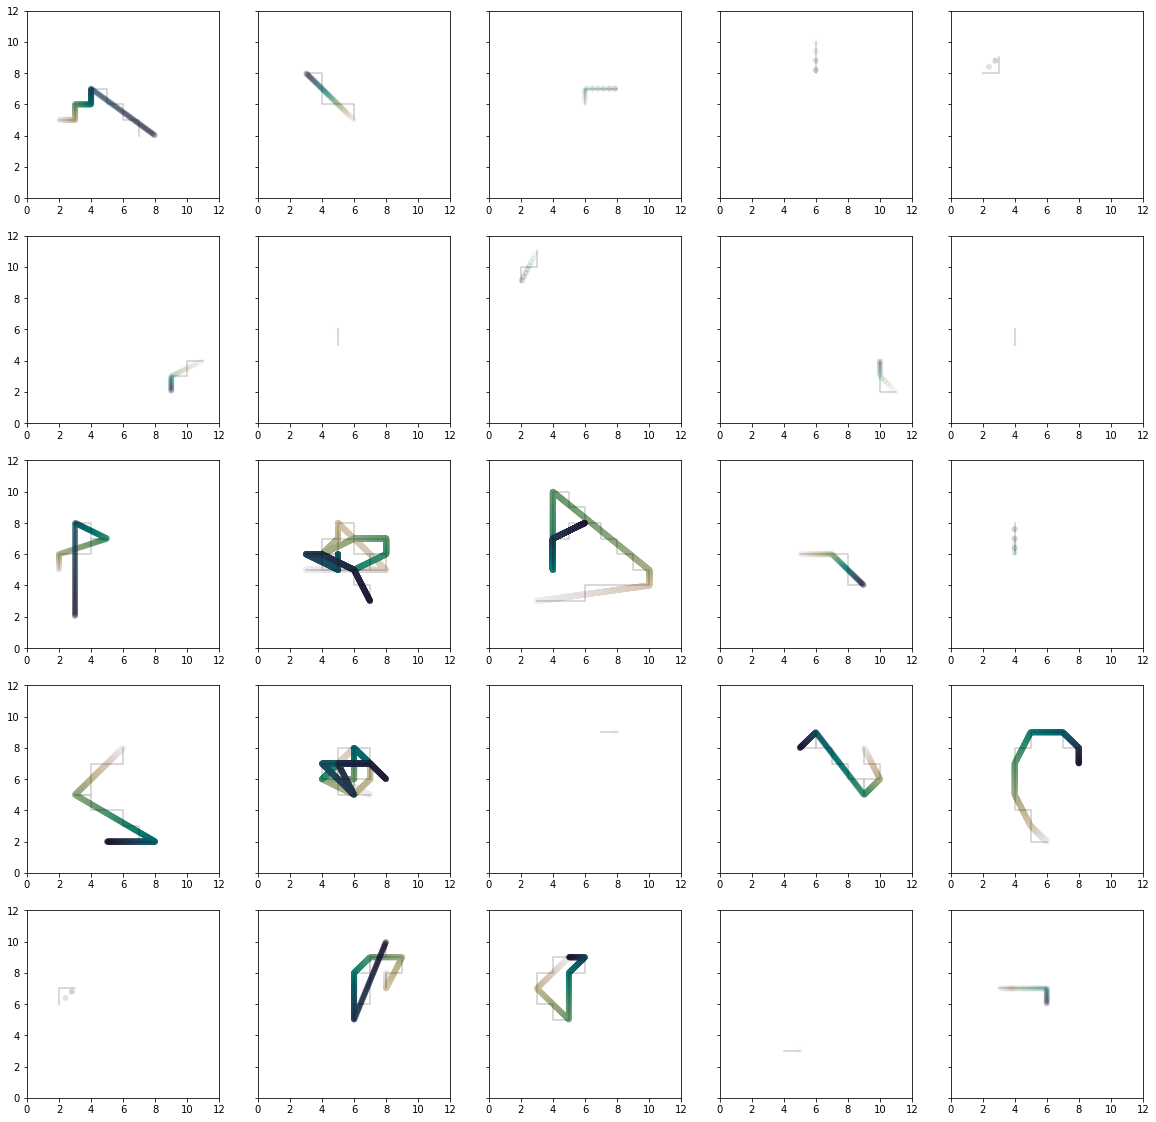

In [45]:
############# grid of plots of individual cells' INTERPOLATED transitions ###################

########### '20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5' performs the exact loop #############

#the square root of plot number
pnum = 5
#randomly choose cells
sample = random.sample(list(transdf.CellID.unique()), pnum**2)

from cmocean import cm
norm = matplotlib.colors.Normalize()
cmm = cm.rain



fig, axes = plt.subplots(pnum,pnum,figsize=(20,20), sharey=True)
s = 0
#make numpy array with heatmap data
for x in range(pnum):
    for y in range(pnum):
        axes[x,y].set_xlim(0,nbins+1)
        axes[x,y].set_ylim(0,nbins+1)
        #get the next cell in the sample
        temp = transdf[transdf.CellID == sample[s]].reset_index(drop=True)
        #if temp is only 1 transition resample
        if len(temp)<2:
            temp = transdf[transdf.CellID == random.sample(list(transdf.CellID.unique()), 1)].reset_index(drop=True)
        #only get continuous frames 
        frames = temp[temp.frame.diff()>1].index.values
        if frames.size>0:
            if temp.index.values[0] != frames[0]:
                frames = np.append(temp.index.values[0], frames)
            if temp.index.values[-1] != frames[-1]:
                frames = np.append(frames, temp.index.values[-1])
            st = random.randrange(len(frames)-1)
            temp = temp.loc[frames[st]:frames[st+1]-1]
#             print(temp)
#         if s == len(sample)-1:
#             temp = alltrans.copy()
#             print(x,y)

        
        #get values of actual transitions based on the interpolated transitions
        fli = temp.frame.to_list()+[temp.frame.to_list()[-1]+1]
        acttemp = TotalFrame[(TotalFrame.CellID==temp.CellID.values[0])&(TotalFrame.frame.isin(fli))].sort_values(by='frame').reset_index(drop=True)
        #interpolate along the trajectory so I can plot dots which will represent the color gradient line
        px = acttemp.PC1bins.to_numpy()
        py = acttemp.PC7bins.to_numpy()
        pz = acttemp.frame.to_numpy()
        dist = np.nansum(scipy.spatial.distance.pdist(temp[['from_x','from_y']]))
        fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
        newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
        fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
        newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
        newz = np.arange(0,len(temp), len(temp)/len(newy))
        if len(newz)>len(newy):
            newz = newz[:-1]
        #normalize to the colors to the length of the trajectory
        norm.autoscale([0,newz.max()])
        #plot the actual transitions
        axes[x,y].scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')
        
        #plot the interpolated transitions
        ix = np.append(temp.from_x.to_numpy(), temp.to_x.to_numpy()[-1])
        iy = np.append(temp.from_y.to_numpy(), temp.to_y.to_numpy()[-1])
        axes[x,y].plot(ix, iy, color ='black', alpha=0.2)
        
        #add one to the sample count
        s = s+1

In [173]:
############## get the actual bin position reconstructions for still images ##########

from CustomFunctions.PCanimation import animate_PCs

avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()

pca = pk.load(open(savedir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10



fourcorners = np.array([[4,7],
[4,3],
[9,3],
[9,7]])



for x in fourcorners:
    #translate pc bins into actual pcs
    PCs = [(PC1bins[x[0]-1]+PC1bins[x[0]])/2, (PC7bins[x[1]-1]+PC7bins[x[1]])/2]

    specificdir = savedir + str(x) + '.vtp'
    animate_PCs(avgpcs, #average value for all PCs generated with the pca
            whichpcs, #which PC number is being reconstructed
            PCs, #list of PCs, [0] is the first PC, [1] is the second
            pca, #actual pca file
            specificdir,
            lmax,)